In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### imports

In [3]:
print(__doc__)

import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import entropy
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

Automatically created module for IPython interactive environment


### utilities

In [4]:
def sigmoid(x):
    return 1 / (1 + (np.e**-x))
                
def clean_documents(docs):
    def clean_doc(doc):
        ''' remove unwanter characters line new line '''

        unwanted_chrs = [')', '(', '{', '}', '\t', '\n', '\r', "'", '"', "!"]
        for unwanted_chr in unwanted_chrs:
            doc = doc.replace(unwanted_chr, ' ')

        return doc.strip()
    
    return [clean_doc(doc) for doc in docs]

### load dataset

In [5]:
# total number of samples needed
datasize = 1000

# retrieve dataset
docs = fetch_20newsgroups(subset='train', shuffle=False, remove=('headers', 'footers', 'quotes'))
docs, old_labels, classes = docs.data[:datasize], docs.target[:datasize], docs.target_names

In [6]:
# the actual labels as np array
old_labels = np.array(old_labels)
labels = np.zeros(old_labels.shape, dtype=int)

# the new classes
label_classes = list(set([x.split('.')[0] for x in classes]))

# restructuring classes  from 19 to less
for label, cl in enumerate(classes):
    labels[old_labels == label] = label_classes.index(cl.split('.')[0])

In [7]:
print(f"there are {len(docs)} docs and {len(label_classes)} classes: {label_classes}")

there are 1000 docs and 7 classes: ['rec', 'misc', 'talk', 'alt', 'soc', 'sci', 'comp']


### clean dataset

In [8]:
# clean out the new line characters from text in docs
clean_docs = clean_documents(docs)
clean_docs[0]

'morgan and guzman will have era s 1 run higher than last year, and  the cubs will be idiots and not pitch harkey as much as hibbard.  castillo won t be good  i think he s a stud pitcher'

### count words

In [9]:
# initialize the count vectorizer
count_vectorizer = CountVectorizer()

# fit it to dataset
count_vectorizer.fit(clean_docs)

# create dataset
word_count = pd.DataFrame(count_vectorizer.vocabulary_, index=[0])

print("word_count shape is", word_count.shape)

word_count shape is (1, 19476)


In [10]:
word_count.head()

,morgan,and,guzman,will,have,era,run,higher,than,last,...,optilink,molested,w4wg,lastdrive,refund,lurch,conical,cornea,skysweepers,skies
0,12098,2746,8904,19022,9063,7336,15421,9215,17511,10791,...,12940,12042,18740,10792,14779,11250,5281,5505,16267,16249


### Prepare Datatset

In [11]:
# create doc count vectors
doc_vectors = count_vectorizer.transform(clean_docs).toarray()

document_word_frequency = pd.DataFrame(doc_vectors, columns=count_vectorizer.get_feature_names())
document_word_binary_frequency = (document_word_frequency > 0).astype('int')

document_word_frequency["__labels__"] = labels
document_word_binary_frequency["__labels__"] = labels

print("document_word_frequency shape is", document_word_frequency.shape)

document_word_frequency shape is (1000, 19477)


In [12]:
print(f"there are {len(clean_docs)} docs and {len(label_classes)} classes")

there are 1000 docs and 7 classes


In [13]:
document_word_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [14]:
document_word_binary_frequency.head()

,00,000,0000,00000000,00000000b,00000001,00000001b,00000010,00000010b,00000011,...,zoom,zoomed,zooming,zubov,zum,zupancic,zx,zx900a,zzz,__labels__
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


### Cherry pick dataset

In [15]:
# trim the data to words that spread round the corpus

#reduce freq in doc to bin value of 1 or 0
word_doc_binary_freqency = document_word_binary_frequency.drop(["__labels__"], axis='columns')

#the sum vertically of bin freq
word_doc_frequency = word_doc_binary_freqency.sum(0) 

### Topic and word corelation

In [29]:
word_topic_cos = []
for topic, label in enumerate(label_classes):
    word_topic_frequency = word_doc_binary_freqency[document_word_frequency['__labels__'] == topic].sum(0)
    trust_factor = sigmoid(word_doc_frequency)
    
    word_topic_co = (word_topic_frequency * trust_factor) / word_doc_frequency
    word_topic_co = word_topic_co[word_topic_co > 0.5].sort_values(ascending=False)
    
    word_topic_cos.append(word_topic_co)
    print(f"topic {topic} has {word_topic_co.shape} skew words")

topic 0 has (3320,) skew words
topic 1 has (410,) skew words
topic 2 has (4516,) skew words
topic 3 has (280,) skew words
topic 4 has (725,) skew words
topic 5 has (3275,) skew words
topic 6 has (2828,) skew words


In [18]:
label_classes

['rec', 'misc', 'talk', 'alt', 'soc', 'sci', 'comp']

In [83]:
topic_index = 6
word_topic_cos[topic_index][word_topic_cos[topic_index] > 0].sort_values(ascending=False)

motif       0.999983
fonts       0.999665
font        0.999089
mouse       0.999089
menu        0.997527
              ...   
computer    0.527778
lines       0.526316
running     0.515152
problem     0.511111
help        0.506329
Length: 2828, dtype: float64

### Word and word corelation

In [173]:
topic_word_window_width = 280
topic_word_distr = pd.DataFrame(data=0.0, columns=label_classes, index=word_doc_binary_freqency.columns)

for topic, word_topic_co in enumerate(word_topic_cos):
    word_word_co = pd.DataFrame(data=0.0, columns=word_topic_co[:topic_word_window_width].index, index=word_doc_binary_freqency.columns)
    
    for index, (top_word, corelation) in enumerate(word_topic_co.items()):
        if index == topic_word_window_width:
            break
            
        word_word_frequency = corelation * word_doc_binary_freqency[word_doc_binary_freqency[top_word] > 0].sum(0)
        trust_factor = sigmoid(word_doc_frequency)

        word_word_co[top_word] = (word_word_frequency * trust_factor) / word_doc_frequency

#         print(label_classes[topic], top_word, corelation, word_word_co.shape)
    topic_word_distr[label_classes[topic]] = word_word_co.max(1)
        
print(f"topic_word_distr has shape {topic_word_distr.shape}")

topic_word_distr has shape (19476, 7)


In [174]:
topic_word_distr.head()

,rec,misc,talk,alt,soc,sci,comp
00,0.142809,0.071425,0.141901,0.000000,0.052608,0.065476,0.062914
000,0.088080,0.049998,0.179992,0.031752,0.036826,0.083127,0.049665
0000,0.717910,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
00000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.731059,0.000000
00000000b,0.000000,0.000000,0.000000,0.000000,0.000000,0.731059,0.000000


In [175]:
word = "computer"
topic_word_distr.loc[word]

rec     0.055418
misc    0.055184
talk    0.000000
alt     0.000000
soc     0.027768
sci     0.083333
comp    0.101851
Name: computer, dtype: float64

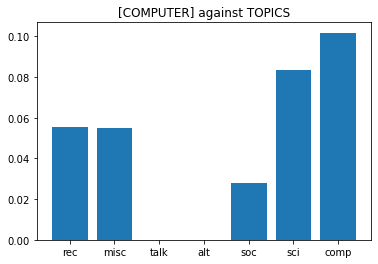

In [176]:
values = topic_word_distr.loc[word]

plt.title(f"[{word.upper()}] against TOPICS")
plt.bar(values.index, values.values)
plt.show()

### Infering topic from document

In [163]:
doc_index = 120
doc_topic_word_distr = topic_word_distr.copy()
doc_word_freq_norm = doc_vectors[doc_index] / doc_vectors[doc_index].sum()

for label_class in label_classes:
    doc_topic_word_distr[label_class] *= doc_word_freq_norm
    
print("doc_topic_word_distr has shape", doc_topic_word_distr.shape)

doc_topic_word_distr has shape (19476, 7)


In [164]:
print("{:8s} {:16s} {:6s}".format("topic", "word", "relation"))
print("="*40)
for label, word in doc_topic_word_distr.idxmax().items():
    print("{:8s} {:16s} {:.4f}".format(label, word, doc_topic_word_distr[label][word]))
    
print(f"\nthe topic predicted is ==> '{np.max(doc_topic_word_distr).idxmax()}'")
print(f"the actual topic is ==> '{label_classes[labels[doc_index]]}'")

topic    word             relation
rec      approved         0.0031
misc     the              0.0005
talk     persons          0.0031
alt      absolutely       0.0007
soc      nature           0.0013
sci      corrupts         0.0228
comp     changed          0.0014

the topic predicted is ==> 'sci'
the actual topic is ==> 'sci'


In [165]:
doc_topic_word_distr.loc["corrupts"]

rec     0.000000
misc    0.000000
talk    0.000000
alt     0.000000
soc     0.000000
sci     0.022846
comp    0.000000
Name: corrupts, dtype: float64